Hola **Robert**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

## Inicialización

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


There isn't any missing value

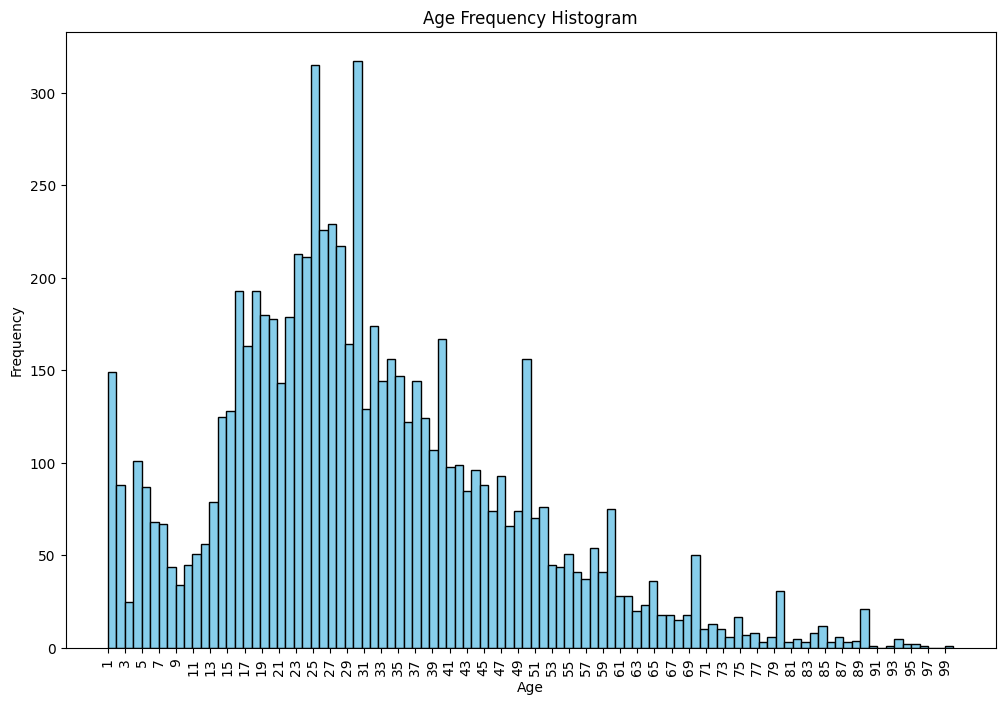

In [4]:
# Define figure size
plt.figure(figsize=(12, 8))

# Graph histogram
df['real_age'].plot(kind='hist', bins=100, edgecolor='black', color='skyblue')

# Add title and labels
plt.title('Age Frequency Histogram')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Setup the ticks for the X axis to show ages
plt.xticks(range(min(df['real_age']), max(df['real_age']) +1, 2), rotation=90)

# Show graph
plt.show()

### Conclusiones

The data distribution of the ages seems to be biased to the right. Most of the data appears to be around 25 years. There is a significant amount of teenagers data which is good for the model in order to distinguish between teenagers and young adults.

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Excelente trabajo con el análisis de tu dataset, cuando se trate de tareas de computer vision siempre es bueno mostrar unos ejemplos de las imágenes con las que se tratará

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [14]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
def load_train(path, subset='training'):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # coloca tu código aquí
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
            )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset=subset,
        seed=12345)

    return train_gen_flow

In [16]:
def load_test(path, subset='validation'):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    # coloca tu código aquí
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255,
            )
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset=subset,
        seed=12345)

    return test_gen_flow

In [17]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    # coloca tu código aquí
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [18]:
def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    # # coloca tu código aquí

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Reduce LROnPlateau to reduce the learning if the metric does not improve
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
    
    model.fit(
        train_data, 
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2
    )

    return model

In [ ]:
input_shape = (224, 224, 3)

train_data = load_train('/content/datasets/datasets/faces/', subset='training')
test_data = load_test('/content/datasets/datasets/faces/', subset='validation')
model = create_model(input_shape)
model = train_model(model, train_data, test_data)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


2025-06-22 18:00:40.600377: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
356/356 - 2333s - loss: 262.4472 - mae: 12.5122 - val_loss: 4613.7837 - val_mae: 65.7296 - 2333s/epoch - 7s/step
Epoch 2/20


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Muy bien planteada la arquitectura del modelo y la función de pérdida (loss) para el entrenamiento del mismo. Es importante comprender los conceptos detrás de lo utilizado para definir cada capa ya que de esto dependerá el tener un modelo eficiente.

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

    # Agregar el código de ejecución (parte que faltaba)
    f.write("""
# =======================
# Modeling start
# =======================

# Dataset path
data_path = '/content/datasets/datasets/faces/'

# Load data
train_data = load_train(data_path, subset='training')
test_data = load_test(data_path, subset='validation')

# Create the model
model = create_model((224, 224, 3))

# Use GPU, if available
if tf.config.list_physical_devices('GPU'):
    print('GPU disponible, el entrenamiento se realizará en la GPU.')
else:
    print('No hay GPU disponible, se utilizará la CPU.')

# Train the model
model = train_model(
    model,
    train_data,
    test_data,
    epochs=3,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=test_data.samples // test_data.batch_size
)

# Save the trained moedl
model.save('trained_model.h5')
""")

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

356/356 - 187s - 527ms/step - loss: 285.3233 - mae: 12.4732 - val_loss: 554.0254 - val_mae: 18.4823
Epoch 2/3
356/356 - 102s - 287ms/step - loss: 141.0556 - mae: 9.0925 - val_loss: 206.0173 - val_mae: 10.8446
Epoch 3/3
356/356 - 106s - 298ms/step - loss: 124.3424 - mae: 8.5109 - val_loss: 107.7531 - val_mae: 7.6221

## Conclusiones

The goal for the metric MAE was achieved!
It was created a good model to predict people's ages with a convulutional neural network

<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteración)</b> <a class="tocSkip"></a>

Muy buen trabajo con el proyecto realizado Robert! Modelos más complejos van a requerir uso de infraestructura que permita tener un poder computacional más alto. En este caso, era necesario una GPU para que el entrenamiento se pueda realizar de manera rápida y con buenos resultados ya que con la GPU puedes paralelizar operaciones de los modelos.

En Deep Learning es importante entender lo que hace cada capa para que la arquitectura sea clara y no se planteé algo a ciegas, muy buen trabajo!

# Lista de control

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos 
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [x]  El valor EAM del modelo no es superior a 8 
- [x]  El código de entrenamiento del modelo se copió en el notebook final 
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [x] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo